In [1]:
import numpy as np
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

from sequitur.models import CONV_LSTM_AE
from sequitur import quick_train

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F

import json
import os
import random
from collections import OrderedDict

In [2]:
track_id2student_id_it = {7:0, 6:1, 0:2, 8:3, 1:4, 3:5, 11:6, 15:7, 16:8, 2:9, 5:12, 9:13, 4:14} # irimi tenkan, my tracking algo
track_id2student_id_ta = {8:0, 7:1, 2:2, 10:3, 3:4, 4:5, 14:6, 9:7, 1:8, 12:9, 11:10, 0:11, 6:12, 5:13} # tsugi ashi, my tracking algo
track_id2student_id_utmt = {7:0, 6:1, 1:2, 8:3, 3:4, 5:5, 11:6, 10:7, 2:8, 0:11, 4:13, 9:9, 12:10, 19:12} # utmt, my tracking algo

single_student_tids = {"1156":0, "1237":1, "0756":0, "0912":0, "1043":0}

In [3]:
file2mapping = {"../alphapose_res/irimi_tenkan_kps.json":track_id2student_id_it,
                "../alphapose_res/ta_tracking.json":track_id2student_id_ta,
                "../alphapose_res/utmt_kps.json":track_id2student_id_utmt}
annotations_map = {"../alphapose_res/irimi_tenkan_kps.json":"../data/irimi_tenkan/annotations.json",
                "../alphapose_res/ta_tracking.json":"../data/tsugi_ashi/annotations.json",
                "../alphapose_res/utmt_kps.json":"../data/ushiro_tenkan_mae_tenkan/annotations.json"}
file2exercise = {"../alphapose_res/irimi_tenkan_kps.json":"ирими тенкан", 
                 "../alphapose_res/ta_tracking.json":"цуги аши",
                 "../alphapose_res/utmt_kps.json":"уширо тенкан мае тенкан"}
single_st_ann = "../data/single_student_annotations.json"


SAMPLE_MAX_FRAME_COUNT = 192 # ?
CHANNELS = 3
EMB_DIM = 2

# Подготовка данных

In [4]:
from dataproc import *
from train_utils import * 

In [5]:
ss_vid_ann = [os.path.join("../alphapose_res", f) for f in ["0756_alpha.json", "0912_alpha.json",
                                                            "1043_alpha.json", "1156_alpha.json", 
                                                            "1237_alpha.json"]]
idx2error, exercise2points, exercise2errors = parse_annotations(file2mapping, single_st_ann, annotations_map, 
                                                                ss_vid_ann, single_student_tids, file2exercise)

## Датасет

In [151]:
class AutoencoderDataset(Dataset):
    def __init__(self, images:list, transform):
        self.transform = transform
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        return self.transform(img)

tform = T.Compose([
    T.Lambda(lambda ar: resample_to_frame_length(ar, SAMPLE_MAX_FRAME_COUNT)),
    #T.Lambda(lambda ar: random_mirroring(ar, 0)),
    T.Lambda(normalize01),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32)
])

def recurr_tform(image):
    ar = resample_to_frame_length(image, SAMPLE_MAX_FRAME_COUNT)
    ar = np.copy(normalize01(ar).reshape((SAMPLE_MAX_FRAME_COUNT, 26, CHANNELS)))
    return torch.tensor(ar, dtype=torch.float32)
# T.Compose([
#     T.Lambda(lambda ar: resample_to_frame_length(ar, SAMPLE_MAX_FRAME_COUNT)),
#     #T.Lambda(lambda ar: random_mirroring(ar, 0)),
#     T.Lambda(normalize01),
#     T.ToTensor(),
#     T.ConvertImageDtype(torch.float32),
#     T.Lambda(lambda t: t.view(SAMPLE_MAX_FRAME_COUNT, 26, CHANNELS))
# ])

In [155]:
# dividing
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

#train_data, test_data, val_data = fraction_split(exercise2points, exercise2errors, train_frac, val_frac, test_frac, 42)
train_data, test_data, val_data = stratify_split(exercise2points, exercise2errors, train_frac, val_frac, test_frac, 42)
train_imgs, train_labels = train_data
test_imgs, test_labels = test_data
val_imgs, val_labels = val_data
total_data_count = len(train_imgs) + len(test_imgs) + len(val_imgs)

print("Total", total_data_count)
print("Train count", len(train_imgs))
print("Test count", len(test_imgs))
print("Val count", len(val_imgs))

Total 297
Train count 208
Test count 56
Val count 33


In [156]:
train_ds_recc = AutoencoderDataset(train_imgs, recurr_tform)
val_ds_recc = AutoencoderDataset(val_imgs, recurr_tform)
test_ds_recc = AutoencoderDataset(test_imgs, recurr_tform)

train_ds = AutoencoderDataset(train_imgs, tform)
val_ds = AutoencoderDataset(val_imgs, tform)
test_ds = AutoencoderDataset(test_imgs, tform)

Dataloader

In [157]:
# setting batch size for Dataloader to load the data batch by batch
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=False)
test_loader = DataLoader(test_ds, 1, shuffle=False)

In [158]:
train_ds[0].shape, train_imgs[0].shape

(torch.Size([3, 26, 192]), (26, 274, 3))

# Полностью сверточный автокодировщик

Код для обучения и архитектуры модели взят из:

https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/

In [161]:
class Encoder(nn.Module):
    def __init__(self, channels, embedding_dim):
        super(Encoder, self).__init__()
        # define convolutional layers
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        # variable to store the shape of the output tensor before flattening
        # the features, it will be used in decoders input while reconstructing
        self.shape_before_flattening = None
        # compute the flattened size after convolutions
        flattened_size = 128 * 4 * 24 # from input of 26 * 192 to 4 * 24
        # define fully connected layer to create embeddings
        self.fc = nn.Linear(flattened_size, embedding_dim)
    def forward(self, x):
        # apply ReLU activations after each convolutional layer
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # store the shape before flattening
        self.shape_before_flattening = x.shape[1:]
        # flatten the tensor
        x = x.view(x.size(0), -1)
        # apply fully connected layer to generate embeddings
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, channels):
        super(Decoder, self).__init__()
        # define fully connected layer to unflatten the embeddings
        self.fc = nn.Linear(embedding_dim, np.prod(shape_before_flattening))
        # store the shape before flattening
        self.reshape_dim = shape_before_flattening
        # define transpose convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            128, 128, kernel_size=3, stride=2, padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=(1, 0), output_padding=(0, 1)
        )
        self.deconv3 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        # define final convolutional layer to generate output image
        self.conv1 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        # apply fully connected layer to unflatten the embeddings
        x = self.fc(x)
        # reshape the tensor to match shape before flattening
        x = x.view(x.size(0), *self.reshape_dim)
        # apply ReLU activations after each transpose convolutional layer
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        # apply sigmoid activation to the final convolutional layer to generate output image
        x = torch.sigmoid(self.conv1(x)) 
        #x = F.tanh(self.conv1(x))
        return x

## Обучение

In [162]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 100
device

'cuda'

In [163]:
encoder = Encoder(channels=CHANNELS, embedding_dim=EMB_DIM).to(device)
# pass the dummy input through the encoder and
# get the output (encoded representation)
dummy_input = torch.rand(1, 3, 26, 192)
enc_out = encoder(dummy_input.to(device))
# get the shape of the tensor before it was flattened in the encoder
shape_before_flattening = encoder.shape_before_flattening
# create a decoder instance with the specified embedding dimensions,
# shape before flattening, and channels
# then move it to the device (CPU or GPU) specified in the config
decoder = Decoder(EMB_DIM, shape_before_flattening, CHANNELS).to(device)
# instantiate loss, optimizer, and scheduler


In [164]:
inprogress_metrics = {"MAE":F.l1_loss} #, "MSE":F.mse_loss

def calc_metrics(preds, targets, inprogress_metrics):
    report = dict()
    for metric in inprogress_metrics:
        metric_func = inprogress_metrics[metric]
        mval = metric_func(preds, targets)
        report[metric] = round(mval.item(), 3)
    return report

def print_report(loss_value, metric_vals, beginning):
    addition = []
    for km in metric_vals:
        formatteds = f"{km}: {metric_vals[km]} "
        addition.append(formatteds)    
    print(beginning, "Loss:", loss_value, "".join(addition))

def train_one_epoch(model, loader, criterion, optimizer, epoch_num):
    model.train()
    running_loss = 0.0
    running_metrics = {k:0.0 for k in inprogress_metrics}
    for batch_idx, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch_num}"):
        # move the data to the device (GPU or CPU)
        data = data.to(device)
        # reset the gradients of the optimizer
        optimizer.zero_grad()
        # forward pass: encode the data and decode the encoded representation
        #encoded = encoder(data)
        decoded = model(data) #decoder(encoded)
        # compute the reconstruction loss between the decoded output and
        # the original data
        loss = criterion(decoded, data)
        # backward pass: compute the gradients
        loss.backward()
        # update the model weights
        optimizer.step()
        # accumulate the loss for the current batch
        running_loss += loss.item()
        metrics = calc_metrics(decoded, data, inprogress_metrics)
        for m in metrics:
            running_metrics[m] += metrics[m]
    # compute the average training loss for the epoch
    train_loss = running_loss / len(loader)
    train_metrics = {k:(running_metrics[k] / len(loader)) for k in running_metrics}
    print_report(train_loss, train_metrics, "Train|")

    res = dict(train_metrics)
    res["loss"] = train_loss
    return res

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_metrics = {k:0.0 for k in inprogress_metrics}
    with torch.no_grad():
        for i, data in enumerate(loader):
            data = data.to(device)
            #encoded = encoder(data)
            decoded = model(data) #decoder(encoded)
            loss = criterion(decoded, data)
            running_loss += loss.item()
            metrics = calc_metrics(decoded, data, inprogress_metrics)
            for m in metrics:
                running_metrics[m] += metrics[m]
    l = running_loss / len(loader)
    scores = {k:(running_metrics[k] / len(loader)) for k in running_metrics}
    print_report(l, scores, "Valid|")
    
    res = dict(scores)
    res["loss"] = l
    return res


In [ ]:
train_history = {n:[] for n in (list(inprogress_metrics.keys())+["loss"])}
val_history = {n:[] for n in (list(inprogress_metrics.keys())+["loss"])}

model0 = nn.Sequential(OrderedDict([
    ('encoder', Encoder(channels=CHANNELS, embedding_dim=EMB_DIM)),
    ('decoder', Decoder(EMB_DIM, shape_before_flattening, CHANNELS))
])).to(device)
criterion = nn.MSELoss() #nn.BCELoss() # MSE, MAE
optimizer = torch.optim.Adam(model0.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=2, verbose=True
)

for epoch in range(epochs):
    #print(f"Epoch: {epoch + 1}/{epochs}")
    tvals = train_one_epoch(model0, train_loader, criterion, optimizer, epoch)
    vvals = evaluate(model0, val_loader, criterion)
    for k in tvals:
        train_history[k].append(tvals[k])
        val_history[k].append(vvals[k])
    # adjust learning rate based on the validation loss
    scheduler.step(vvals["loss"])
    

In [166]:
# displaying losses
def plot_metrics(train_hist:dict, val_hist:dict):
    metrics_name = [metr_name for metr_name in train_hist if metr_name!="loss"]
    plot_counts = len(metrics_name)
    fig, axs = plt.subplots(1, len(metrics_name), figsize=(9, 3), squeeze=False)
    for idx, mname in enumerate(metrics_name):
        train_mvals = train_hist[mname]
        val_mvals = val_hist[mname]
        axs[0, idx].plot(train_mvals, '-b')
        axs[0, idx].plot(val_mvals, '-r')
        axs[0, idx].set_xlabel(mname)
        axs[0, idx].legend(['Training', 'Validation'])
    fig.suptitle(', '.join(metrics_name)+' vs No. of epochs');
    
def plot_losses(train_hist:dict, val_hist:dict, loss_name:str):
    train_losses = train_hist["loss"]
    val_losses = val_hist["loss"]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title(f'{loss_name} Loss vs. No. of epochs');

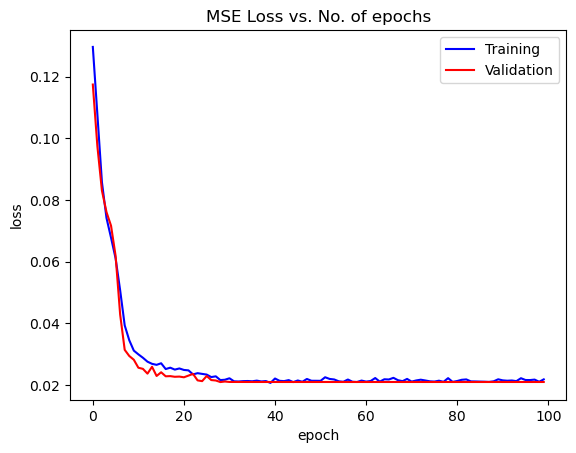

In [167]:
plot_losses(train_history, val_history, "MSE")

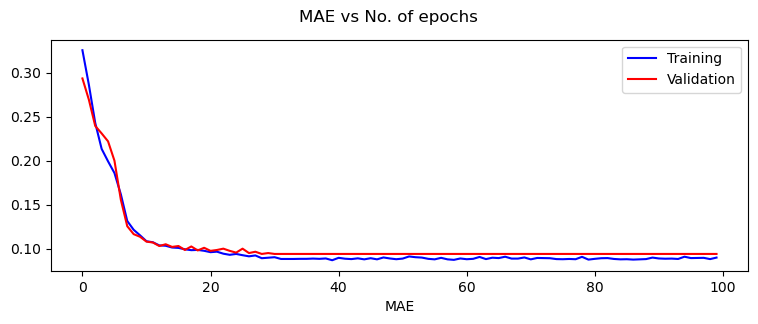

In [168]:
plot_metrics(train_history, val_history)

## Тестирование

In [178]:
model0.eval()

def test_model(model, test_loader, inprogress_metrics, reformat_func):
    preds = []
    trues = []
    test_history = {k:0.0 for k in inprogress_metrics}
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            decoded = model(data)
            trues.append(reformat_func(data))
            preds.append(reformat_func(decoded))
            loss = criterion(decoded, data)
            running_loss += loss.item()
            metrics = calc_metrics(decoded, data, inprogress_metrics)
            for m in metrics:
                test_history[m] += metrics[m]
    l = running_loss / len(test_loader)
    scores = {k:(test_history[k] / len(test_loader)) for k in test_history}
    print_report(l, scores, "Test|")
    return preds, trues

reform_func0 = lambda x: x.cpu().permute((0, 2, 3, 1)).numpy().squeeze()
preds, trues = test_model(model0, test_loader, inprogress_metrics, reform_func0);

Test| Loss: 0.022757509906244065 MAE: 0.09157142857142855 


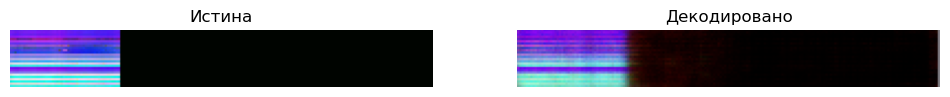

In [179]:
def compare_true_recon(inp_img, decoded):
    fig, axs = plt.subplots(1, 2, figsize=(12, 16))
    axs[0].imshow(inp_img)
    axs[0].set_title("Истина")
    axs[0].axis("off")
    axs[1].imshow(decoded)
    axs[1].set_title("Декодировано")
    axs[1].axis("off")
    plt.show()

compare_true_recon(trues[10], preds[10])

# Conv-LSTM автокодировщик

In [173]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1 = CONV_LSTM_AE((26, CHANNELS), EMB_DIM, kernel=(3, 3), h_lstm_channels=[4]).to(device)
epochs = 50
inprogress_metrics = {"MAE":F.l1_loss} #, "MSE":F.mse_loss
criterion = nn.MSELoss() #nn.BCELoss() # MSE, MAE
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
train_history = {n:[] for n in (list(inprogress_metrics.keys())+["loss"])}
val_history = {n:[] for n in (list(inprogress_metrics.keys())+["loss"])}
for epoch in range(epochs):
    tvals = train_one_epoch(model1, train_ds_recc, criterion, optimizer, epoch)
    vvals = evaluate(model1, val_ds_recc, criterion)
    for k in tvals:
        train_history[k].append(tvals[k])
        val_history[k].append(vvals[k])

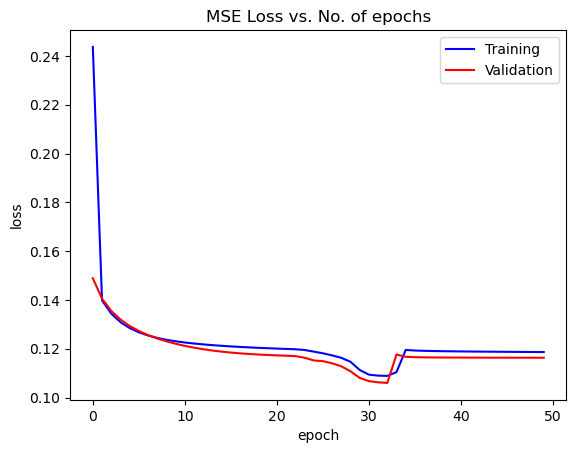

In [175]:
plot_losses(train_history, val_history, "MSE")

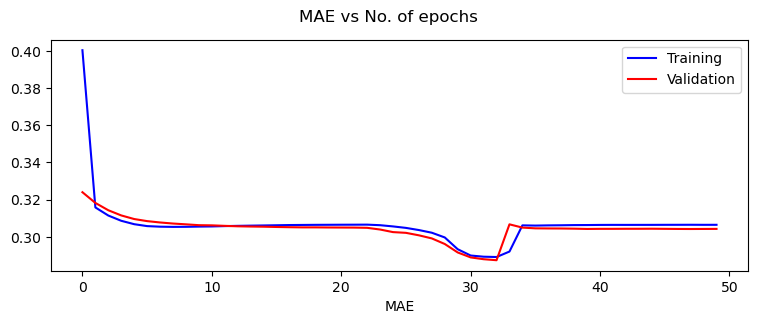

In [176]:
plot_metrics(train_history, val_history)

Test| Loss: 0.11613792373931833 MAE: 0.3028035714285715 


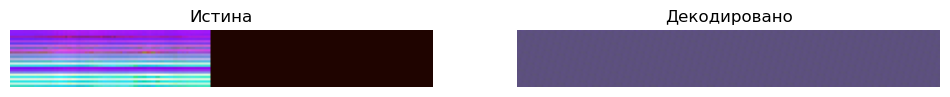

In [180]:
model1.eval()
reform_func1 = lambda x: x.cpu().reshape(26, SAMPLE_MAX_FRAME_COUNT, CHANNELS).numpy()
preds, trues = test_model(model1, test_ds_recc, inprogress_metrics, reform_func1)
compare_true_recon(trues[2], preds[2])

# Исследование эмбеддингов

In [181]:
model0.eval()
model1.eval()
encoder0 = model0.encoder
encoder1 = model1.encoder

In [182]:
def get_motion_embedding(enc, motion_img, transforms, add_batch_dim=True):
    if add_batch_dim:
        prepared_inp = transforms(motion_img).to(device).unsqueeze(0)
    else:
        prepared_inp = transforms(motion_img).to(device)
    return enc(prepared_inp).cpu().detach().numpy().squeeze()

def show_2d_embeddings(enc_model, data, transforms, axs=None, add_batch_dim=True):
    embeddings = []
    for motion in data:
        emb = get_motion_embedding(enc_model, motion, transforms, add_batch_dim)
        embeddings.append(emb)
    embeddings = np.array(embeddings)    
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    if axs:
        axs.scatter(x, y)
    else:
        plt.scatter(x, y)

### Общие характеристики

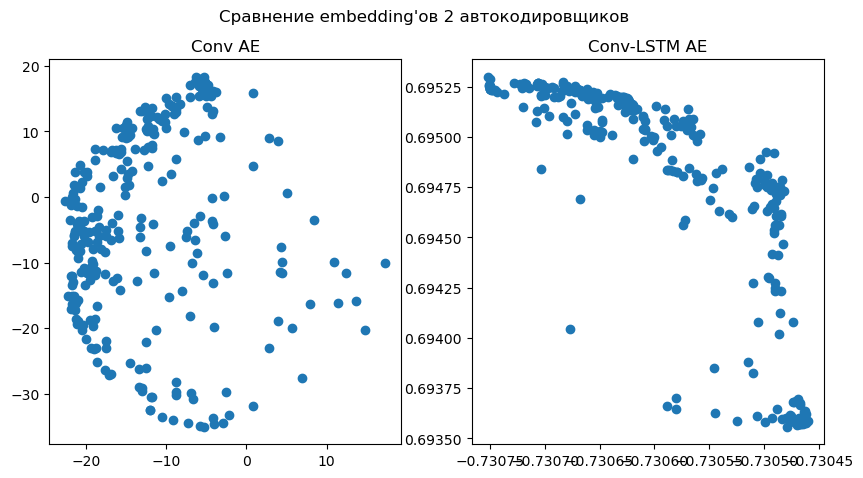

In [183]:
all_data = train_imgs + test_imgs + val_imgs
fig = plt.figure(1, figsize=(10, 5))
ax = fig.add_subplot(1,2,1)
show_2d_embeddings(encoder0, all_data, tform)
ax.title.set_text("Conv AE")
ax = fig.add_subplot(1,2,2)
show_2d_embeddings(encoder1, all_data, recurr_tform, add_batch_dim=False)
ax.title.set_text("Conv-LSTM AE")
fig.suptitle("Сравнение embedding'ов 2 автокодировщиков")
plt.show()

### По ошибкам

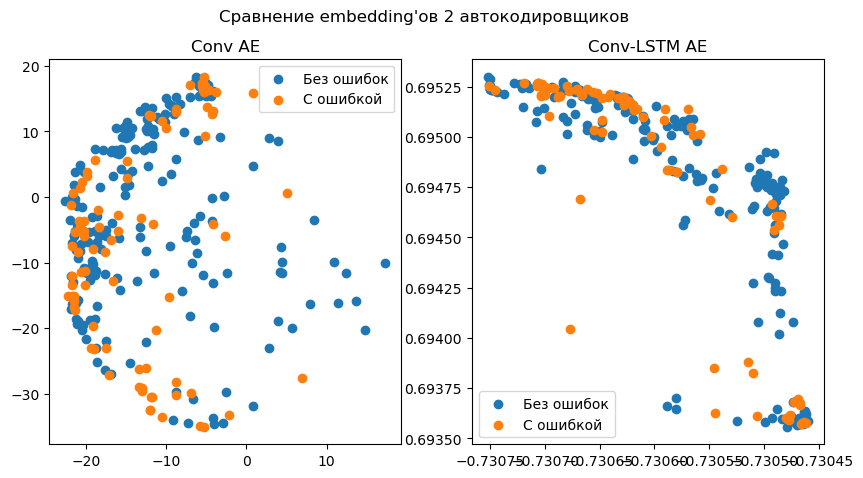

In [184]:
# separate on mistakes
normal = []
wrong = []
for motions, labels in zip([train_imgs, test_imgs, val_imgs], [train_labels, test_labels, val_labels]):
    for idx, motion in enumerate(motions):
        if labels[idx][0] != 0: # with errors
            wrong.append(motion)
        else:
            normal.append(motion)

# show compare plots
fig = plt.figure(2, figsize=(10, 5))
ax = fig.add_subplot(1,2,1)
show_2d_embeddings(encoder0, normal, tform)
show_2d_embeddings(encoder0, wrong, tform)
ax.title.set_text("Conv AE")
ax.legend(["Без ошибок", "С ошибкой"])
ax = fig.add_subplot(1,2,2)
show_2d_embeddings(encoder1, normal, recurr_tform, add_batch_dim=False)
show_2d_embeddings(encoder1, wrong, recurr_tform, add_batch_dim=False)
ax.title.set_text("Conv-LSTM AE")
ax.legend(["Без ошибок", "С ошибкой"])
fig.suptitle("Сравнение embedding'ов 2 автокодировщиков")
plt.show()

### По упражнениям

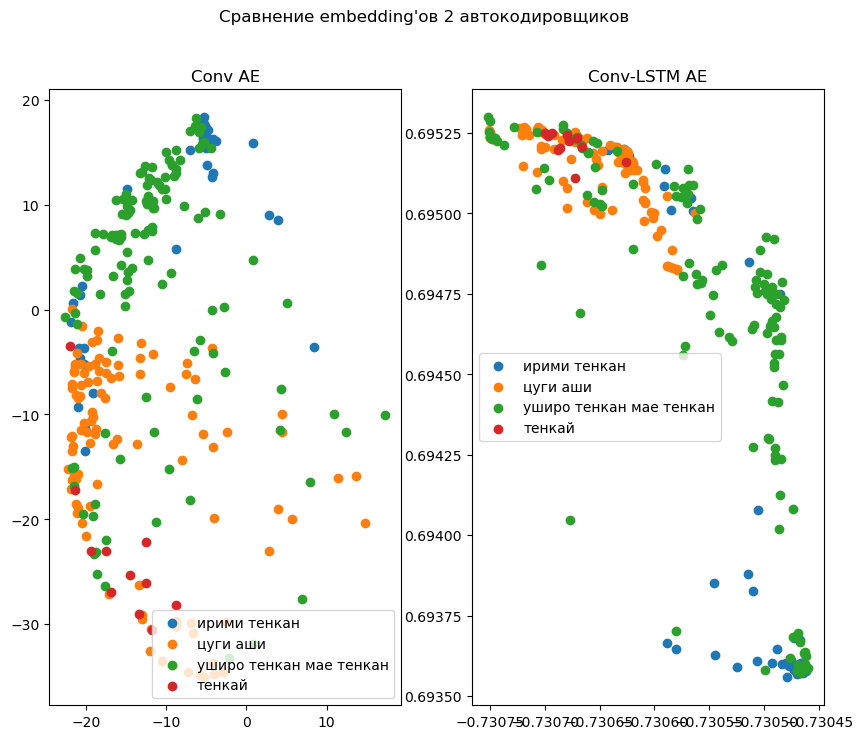

In [188]:
exercises_legend = []
fig, axss = plt.subplots(1, 2, figsize=(10, 8))
for exercise in exercise2points:
    exercises_legend.append(exercise)
    cur_exercises = []
    for person in exercise2points[exercise]:
        for motion in exercise2points[exercise][person]:
            cur_exercises.append(motion)
    show_2d_embeddings(encoder0, cur_exercises, tform, axs=axss[0])
    show_2d_embeddings(encoder1, cur_exercises, recurr_tform, add_batch_dim=False, axs=axss[1])
axss[0].legend(exercises_legend)
axss[0].title.set_text("Conv AE")
axss[1].legend(exercises_legend)
axss[1].title.set_text("Conv-LSTM AE")
fig.suptitle("Сравнение embedding'ов 2 автокодировщиков")
plt.show()

### По упражнениям и ошибкам

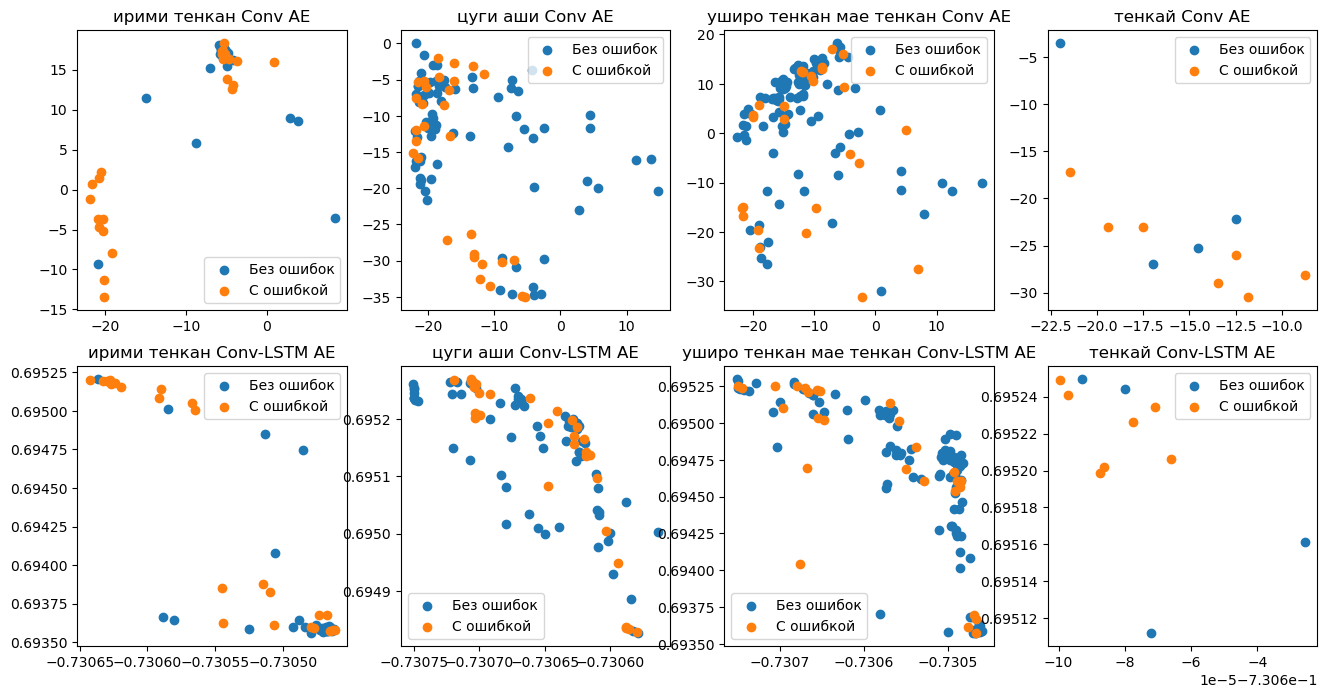

In [190]:
fig, axs = plt.subplots(2, len(exercise2points), figsize=(16, 8))
for idx, exname in enumerate(exercise2points):
    wrong_exercises = []
    normal_exercises = []
    for student in exercise2points[exname]:
        for m_idx, motion in enumerate(exercise2points[exname][student]):
            if exercise2errors[exname][student][m_idx][0] != 0:
                wrong_exercises.append(motion)
            else:
                normal_exercises.append(motion)
    show_2d_embeddings(encoder0, normal_exercises, tform, axs[0, idx])
    show_2d_embeddings(encoder0, wrong_exercises, tform, axs[0, idx])
    axs[0, idx].legend(["Без ошибок", "С ошибкой"])
    axs[0, idx].title.set_text(f"{exname} Conv AE")
    show_2d_embeddings(encoder1, normal_exercises, recurr_tform, add_batch_dim=False, axs=axs[1, idx])
    show_2d_embeddings(encoder1, wrong_exercises, recurr_tform, add_batch_dim=False, axs=axs[1, idx])
    axs[1, idx].legend(["Без ошибок", "С ошибкой"])
    axs[1, idx].title.set_text(f"{exname} Conv-LSTM AE")
plt.show()